# Trabalho 1 - Machine Learning II 
Prof: Carlos Padilha

#### Alunos:  

Roberto A. Coutinho  
Thais Galho


## Sistemas com Multi-classificadores ou Ensembles

#### Este trabalho visa avaliar o entendimento em relaçãao á construção de sistemas com multi-classificadores ou ensembles. Para tal, os alunos deverão fazer o seguinte:


* Implementar o algoritmo AdaBoost (nos mesmos moldes que fizemos com o algoritmo Bagging).
    – Podem escolher qualquer tipo de classificador (MLP, SVM, etc).
* Processar os dados presente no arquivo sonar.all-data.
* Realizar treinamento e teste usando validação cruzada com 10 folds.
* Avaliar os resultados em termos de acurácia, recall e precisão.

Obs: O trabalho pode ser feito em dupla e deve ser enviado por email (carlos.engcomp@gmail.com).

In [2]:
import numpy as np
import pandas as pd

# Modelos
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# K-fold CrossValidation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [125]:
imported_data = pd.read_csv('sonar.all-data.csv', header=None)

imported_data.iloc[:,-1] = imported_data.iloc[:,-1].astype('category')
categories = imported_data.select_dtypes(['category']).columns
imported_data[categories] = imported_data[categories].apply(lambda x:x.cat.codes) 

imported_data = imported_data.sample(frac=1).reset_index(drop=True)

imported_data.head(50)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,1
1,0.0635,0.0709,0.0453,0.0333,0.0185,0.1260,0.1015,0.1918,0.3362,0.3900,...,0.0048,0.0025,0.0087,0.0072,0.0095,0.0086,0.0085,0.0040,0.0051,0
2,0.1088,0.1278,0.0926,0.1234,0.1276,0.1731,0.1948,0.4262,0.6828,0.5761,...,0.0455,0.0213,0.0082,0.0124,0.0167,0.0103,0.0205,0.0178,0.0187,0
3,0.0107,0.0453,0.0289,0.0713,0.1075,0.1019,0.1606,0.2119,0.3061,0.2936,...,0.0164,0.0120,0.0113,0.0021,0.0097,0.0072,0.0060,0.0017,0.0036,0
4,0.0228,0.0106,0.0130,0.0842,0.1117,0.1506,0.1776,0.0997,0.1428,0.2227,...,0.0098,0.0178,0.0077,0.0074,0.0095,0.0055,0.0045,0.0063,0.0039,0
5,0.0707,0.1252,0.1447,0.1644,0.1693,0.0844,0.0715,0.0947,0.1583,0.1247,...,0.0156,0.0197,0.0135,0.0127,0.0138,0.0133,0.0131,0.0154,0.0218,0
6,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,0
7,0.0442,0.0477,0.0049,0.0581,0.0278,0.0678,0.1664,0.1490,0.0974,0.1268,...,0.0204,0.0216,0.0135,0.0055,0.0073,0.0080,0.0105,0.0059,0.0105,1
8,0.0336,0.0294,0.0476,0.0539,0.0794,0.0804,0.1136,0.1228,0.1235,0.0842,...,0.0150,0.0111,0.0032,0.0035,0.0169,0.0137,0.0015,0.0069,0.0051,1
9,0.0294,0.0123,0.0117,0.0113,0.0497,0.0998,0.1326,0.1117,0.2984,0.3473,...,0.0056,0.0104,0.0079,0.0014,0.0054,0.0015,0.0006,0.0081,0.0043,0


In [126]:
from sklearn import preprocessing
# Separação entre dados e labels

labels = imported_data.iloc[:,-1]

data = imported_data.iloc[:,:-1]
len(data), len(labels)

(208, 208)

In [136]:
#labels.head(100)

In [128]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score

def printCM(Y_test, predictions):
    cm = confusion_matrix(Y_test, predictions)
    acc_score = accuracy_score(Y_test, predictions)
    prec_score = precision_score(Y_test, predictions, average='weighted')
    
    print ('Confusion Matrix : ')
    print (cm)
    print
    
    tn = float(cm[0][0])
    fp = float(cm[0][1])
    fn = float(cm[1][0])
    tp = float(cm[1][1])

    actual_yes = fn+tp
    actual_no = tn+fp
    predicted_yes = fp+tp
    predicted_no = tn+fn

    total = float(len(imported_data))
    print ('Total : '+ str(total))

    print ('Acurácia : ' + str(acc_score))

    misclassification_rate = round((fp+fn)/total,3) # Overall, how often is it wrong?
    print ('Misclassification rate : ' +str(misclassification_rate))

    true_positive = round(tp/actual_yes,3) # When it's actually yes, how often does it predict yes?
    print ('True positives : ' +str(true_positive))

    false_positive = round(fp/actual_no,3) # When it's actually no, how often does it predict yes?
    print ('False positives : ' +str(false_positive))

    specificity = round(tn/actual_no,3) # When it's actually no, how often does it predict no?
    print ('Specificity : ' +str(specificity))

    #precision = round(tp/predicted_yes,3) # When it predicts yes, how often is it correct?
    print ('Precision : ' +str(prec_score))

    prevalence = round(actual_yes/total,3) # How often does the yes condition actually occur in our sample?
    print ('Prevalence : ' +str(prevalence))
    
    recall = round(tp / (tp + fn), 3)
    print ('Recall : ' +str(recall))

    #f1 = round(2 * ((precision * true_positive) / (precision + true_positive)),3)
    #print ('F1 Score : ' +str(f1))
    
    return acc_score, prec_score, recall

In [146]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

def print_error_rate(err):
    print('Error rate: Training: %.4f - Test: %.4f' % err)


<h2>Separação entre treino e teste</h2>

In [144]:

# utiliza 25% do dataset para teste
trainData, validationData, trainLabels, validationLabels = train_test_split(data, labels, 
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    stratify=labels,
                                                    random_state=43)

print(len(trainData), len(trainLabels))
print(len(validationData), len(validationLabels))

166 166
42 42


In [150]:
scores = []
scores_test = []
error_train = []
error_test = []



# Define quantos folds
kf = KFold(n_splits=10)

alpha = 0.5

print()
print("....Iniciando treinamento com 10 K-folds...." )
print()

kfold = 0    
for train_index, test_index in kf.split(trainData):
    
    print("################################################")
    print("K-fold : "+str(kfold+1))    
    print("################################################")
    print(train_index, test_index)
    print()

    # Obten os subdados de treinamento e teste no n fold
    #---------------------------------------------------------------------
    X_train, X_test = trainData.iloc[train_index,:], trainData.iloc[test_index,:]
    #print(len(X_train), len(X_test))

    y_train, y_test = trainLabels.iloc[train_index], trainLabels.iloc[test_index]
    #print(len(y_train), len(y_test))
    
    print("....Inicializando vetor de pesos....")
    print()


    n_train, n_test = len(X_train), len(X_test)
    #pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]

    # Initialize weights
    w = np.ones(n_train) / n_train
    print(w)
    
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    print(pred_train)
    
    # Fit um classificador
    model = DecisionTreeClassifier(max_depth = 1, random_state = 1)
    
    model_index = 0
    for i in range(10):
        print()
        # Treina o modelo de classificação
        #---------------------------------------------------------------------
        print("Treinando o modelo....")

        # Treina o classificador com os pesos de treinamento
        model.fit(X=X_train, y=y_train, sample_weight=w)
        print(model)

        # Classifica o treino
        pred_train_i = model.predict(X_train)
        #print(pred_train_i)

        # Classifica o teste
        pred_test_i = model.predict(X_test)
        #print(pred_test_i)        

        print()
        print("...:::: Avaliação ::::....  ")
        print()

        # Obtem o index dos erros da classificação de treino e teste
        #---------------------------------------------------------------------
        missTrain = [int(x) for x in (pred_train_i != y_train)]
        #print("Training Miss : "+str(missTrain))
        missTest = [int(x) for x in (pred_test_i != y_test)]
        #print("Testing Miss : "+str(missTest))

        # Equivale os valores entre 1/-1 para atualização dos pesos
        #---------------------------------------------------------------------
        miss2Train = [x if x==1 else -1 for x in missTrain]
        #print("Training Miss2 : "+str(miss2))
        miss2Test = [x if x==1 else -1 for x in missTest]
        #print("Testing Miss2 : "+str(miss2Test))


        # Calcula o erro
        #---------------------------------------------------------------------
        err_m = np.dot(w, missTrain) / sum(w)
        print("Error : "+str(err_m))

        # Calcula o Alpha 
        #---------------------------------------------------------------------
        alpha_m = alpha * np.log( (1 - err_m) / float(err_m))
        print("Alpha : "+str(alpha_m))


        # Mostra a Matriz de Confusão para treino e teste
        #---------------------------------------------------------------------
        print()
        print(":: Treinamento :: ")
        print("")
        train_acc_score, train_precision_score, train_recall_score = printCM(y_train, pred_train_i)

        print()
        print(":: Teste ::")
        print()
        test_acc_score, test_precision_score, test_recall_score = printCM(y_test, pred_test_i)
        print


        # Atualiza os valores dos pesos
        #---------------------------------------------------------------------
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2Train]))
        print()
        print("Novos pesos atualizados : ")
        print(w)
        print()
        print("---------------------------------------------------------------------------")
        print()


        scores.append([kfold, model_index, train_acc_score, train_precision_score, train_recall_score, err_m, alpha_m, model])
        scores_test.append([kfold, model_index, test_acc_score, test_precision_score, test_recall_score, err_m, alpha_m, model])
    
        error_train.append([i, err_m])
    
        model_index += 1
        # Add to prediction
        ##pred_train = [sum(x) for x in zip(pred_train, [x * alpha_m for x in pred_train_i])]
        ##pred_test = [sum(x) for x in zip(pred_test, [x * alpha_m for x in pred_test_i])]
        
    ##pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    
    print()
    print()
    kfold += 1 
    print
    print


....Iniciando treinamento com 10 K-folds....

################################################
K-fold : 1
################################################
[ 17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

....Inicializando vetor de pesos....

[0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141
 0.00671141 

Confusion Matrix : 
[[9 1]
 [6 1]]
Total : 208.0
Acurácia : 0.5882352941176471
Misclassification rate : 0.034
True positives : 0.143
False positives : 0.1
Specificity : 0.9
Precision : 0.5588235294117647
Prevalence : 0.034
Recall : 0.143

Novos pesos atualizados : 
[0.00392709 0.00378505 0.01146982 0.00180281 0.00825395 0.00545127
 0.00162476 0.00180281 0.00825395 0.00180281 0.00168573 0.00378914
 0.00378914 0.00378914 0.00510274 0.00491818 0.00168573 0.00510274
 0.00162476 0.00077303 0.00392709 0.00392709 0.00392709 0.00168573
 0.00162476 0.00510274 0.00168573 0.00168573 0.00826285 0.00168573
 0.00545715 0.00168573 0.00545127 0.02772295 0.00491818 0.00392709
 0.00545127 0.00180281 0.00378914 0.00378914 0.00392709 0.00419984
 0.00545127 0.00825395 0.00419984 0.01188741 0.00354306 0.00392709
 0.00378914 0.00180281 0.00180281 0.00491818 0.00180281 0.00168573
 0.01146982 0.00392709 0.00077303 0.00378914 0.00162476 0.00162476
 0.00378505 0.00180281 0.00378914 0.00545127 0.00915848 0.003789

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.361497931564521
Alpha : 0.2844342976105925

:: Treinamento :: 

Confusion Matrix : 
[[26 58]
 [ 3 62]]
Total : 208.0
Acurácia : 0.5906040268456376
Misclassification rate : 0.293
True positives : 0.954
False positives : 0.69
Specificity : 0.31
Precision : 0.730830054771272
Prevalence : 0.312
Recall : 0.954

:: Teste ::

Confusion Matrix : 
[[ 1  4]
 [ 2 10]]
Total : 208.0
Acurácia : 0.6470588235294118
Misclassification rate : 0.029
True positives : 0.833
False positives : 0.8
Specificity : 0.2
Precision : 0.6022408963585434
Prevalence : 0.058
Recall : 0.833

Novos pesos atualizados : 
[0.00398856 0.00502681 0

 0.00671141 0.00671141 0.00671141 0.00671141 0.00671141]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]

Treinando o modelo....
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.24161073825503387
Alpha : 0.5719344401281145

:: Treinamento :: 

Confusion Mat

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

...:::: Avaliação ::::....  

Error : 0.29015153474223926
Alpha : 0.4473240989701874

:: Treinamento :: 

Confusion Matrix : 
[[29 49]
 [12 59]]
Total : 208.0
Acurácia : 0.5906040268456376
Misclassification rate : 0.293
True positives : 0.831
False positives : 0.628
Specificity : 0.372
Precision : 0.6305890519755308
Prevalence : 0.341
Recall : 0.831

:: Teste ::

Confusion Matrix : 
[[5 6]
 [1 5]]
Total : 208.0
Acurácia : 0.5882352941176471
Misclassification rate : 0.034
True positives : 0.833
False positives : 0.545
Specificity : 0.455
Precision : 0.6996434937611409
Prevalence : 0.029
Recall : 0.833

Novos pesos atualizados : 
[0.00232582 0.00542

/Users/roberto/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion Matrix : 
[[74  7]
 [51 18]]
Total : 208.0
Acurácia : 0.6133333333333333
Misclassification rate : 0.279
True positives : 0.261
False positives : 0.086
Specificity : 0.914
Precision : 0.65088
Prevalence : 0.332
Recall : 0.261

:: Teste ::

Confusion Matrix : 
[[8 0]
 [7 1]]
Total : 208.0
Acurácia : 0.5625
Misclassification rate : 0.034
True positives : 0.125
False positives : 0.0
Specificity : 1.0
Precision : 0.7666666666666666
Prevalence : 0.038
Recall : 0.125

Novos pesos atualizados : 
[0.00292529 0.00216691 0.00661786 0.00259556 0.00292529 0.00345285
 0.00216691 0.00216691 0.00292529 0.00259556 0.00292529 0.00497475
 0.00497475 0.00216691 0.02051052 0.00661786 0.00671583 0.00113058
 0.00345285 0.00661786 0.00216691 0.00216691 0.00292529 0.00292529
 0.00560673 0.00345285 0.00292529 0.00216691 0.00216691 0.00259556
 0.00292529 0.00497475 0.00216691 0.00671583 0.008934   0.00216691
 0.00113058 0.00292529 0.00671583 0.00292529 0.00292529 0.00216691
 0.008934   0.00292529 0.002

Confusion Matrix : 
[[71  9]
 [29 41]]
Total : 208.0
Acurácia : 0.7466666666666667
Misclassification rate : 0.183
True positives : 0.586
False positives : 0.113
Specificity : 0.887
Precision : 0.7613333333333333
Prevalence : 0.337
Recall : 0.586

:: Teste ::

Confusion Matrix : 
[[8 1]
 [4 3]]
Total : 208.0
Acurácia : 0.6875
Misclassification rate : 0.024
True positives : 0.429
False positives : 0.111
Specificity : 0.889
Precision : 0.703125
Prevalence : 0.034
Recall : 0.429

Novos pesos atualizados : 
[0.00309839 0.01734745 0.00621374 0.00135522 0.00469413 0.00253261
 0.00092695 0.00077079 0.00998111 0.00135522 0.00054398 0.00213985
 0.00213985 0.00092695 0.01789928 0.01734745 0.00256202 0.00028775
 0.00253261 0.00815852 0.00248303 0.00092695 0.00054398 0.00054398
 0.00175238 0.01098653 0.00115667 0.00248303 0.00248303 0.00135522
 0.00110982 0.00213985 0.00248303 0.00256202 0.00775367 0.00092695
 0.00124826 0.00115667 0.00632127 0.00235981 0.00054398 0.00189114
 0.00380049 0.00054398 

Confusion Matrix : 
[[8 3]
 [1 4]]
Total : 208.0
Acurácia : 0.75
Misclassification rate : 0.019
True positives : 0.8
False positives : 0.273
Specificity : 0.727
Precision : 0.7896825396825395
Prevalence : 0.024
Recall : 0.8

Novos pesos atualizados : 
[0.00111378 0.00239704 0.00273063 0.00256027 0.00111378 0.00133602
 0.00093629 0.00112159 0.00698519 0.00103474 0.0011027  0.00088172
 0.00088172 0.0003784  0.0074935  0.00706496 0.00254244 0.00044878
 0.00812252 0.00706496 0.0009457  0.00237319 0.00044565 0.0011027
 0.00230055 0.00829107 0.00044565 0.0009457  0.0009457  0.00103474
 0.0026998  0.00088172 0.00233997 0.00254244 0.00815138 0.0003784
 0.00278505 0.00112959 0.01610546 0.00684311 0.00044565 0.00229238
 0.00332931 0.00044565 0.0011027  0.00230055 0.0011027  0.00781207
 0.00109113 0.00829107 0.00775765 0.00282689 0.00103842 0.00829107
 0.00042262 0.00223486 0.00220358 0.00276565 0.00256027 0.00311306
 0.00232367 0.00045329 0.00328272 0.00232367 0.00272694 0.00218165
 0.00109878 0

In [155]:
error_train

[[0, 0.23489932885906067],
 [1, 0.33032581453634086],
 [2, 0.26916391988405547],
 [3, 0.32960639871747777],
 [4, 0.2688210741082501],
 [5, 0.2909425261559668],
 [6, 0.290505664233224],
 [7, 0.3063719047258378],
 [8, 0.2715534734507066],
 [9, 0.26684629567876683],
 [0, 0.24832214765100702],
 [1, 0.3223938223938217],
 [2, 0.3003352269819334],
 [3, 0.30010861594741883],
 [4, 0.31439917452435057],
 [5, 0.3529680664260112],
 [6, 0.3123303322509476],
 [7, 0.29673599061966477],
 [8, 0.29795883890641567],
 [9, 0.25660291917041383],
 [0, 0.22147651006711436],
 [1, 0.2979362591431558],
 [2, 0.2770144469479923],
 [3, 0.2861489309780387],
 [4, 0.3432331064364485],
 [5, 0.26701962007323327],
 [6, 0.33616481227237355],
 [7, 0.27858564709863964],
 [8, 0.361497931564521],
 [9, 0.3021321639398614],
 [0, 0.24161073825503385],
 [1, 0.354965585054081],
 [2, 0.2841013698398764],
 [3, 0.29229124483183283],
 [4, 0.3055109663036106],
 [5, 0.2996451919013844],
 [6, 0.3248372582648343],
 [7, 0.282666012852263],

Text(0.5,1,'Error rate vs number of iterations')

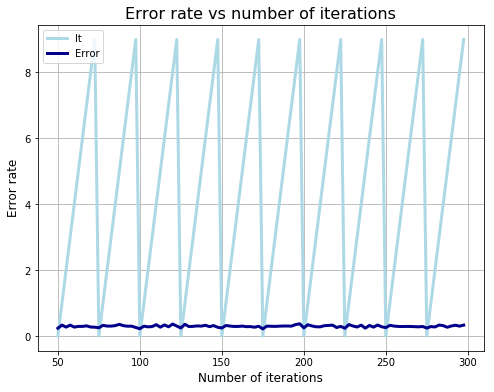

In [157]:
import matplotlib.pyplot as plt

df_error = pd.DataFrame(error_train)
df_error.head(10)
df_error.columns = ['It', 'Error']
plot1 = df_error.plot(linewidth = 3, 
                      figsize = (8,6),
                      color = ['lightblue', 'darkblue'], 
                      grid = True)
plot1.set_xlabel('Number of iterations', fontsize = 12)
plot1.set_xticklabels(range(0,450,50))
plot1.set_ylabel('Error rate', fontsize = 12)
plot1.set_title('Error rate vs number of iterations', fontsize = 16)
#plt.axhline(y=error_test[0], linewidth=1, color = 'red', ls = 'dashed')

<h2>Apresentação dos Resultados</h2>

In [135]:
scoresDF = pd.DataFrame(scores, columns=["n-fold", 
                                         "Model Idx",
                                         "Acc", 
                                         "Precision", 
                                         "Recall",
                                         "Error", 
                                         "Alpha", 
                                         "Model"])

#scoresDF.sort_values(["Acc","Error"], ascending=False)
scoresDF

,n-fold,Model Idx,Acc,Precision,Recall,Error,Alpha,Model
0,0,0,0.765101,0.768952,0.671,0.234899,0.590425,"DecisionTreeClassifier(class_weight=None, crit..."
1,0,1,0.630872,0.741690,0.957,0.330326,0.353356,"DecisionTreeClassifier(class_weight=None, crit..."
2,0,2,0.657718,0.665312,0.486,0.269164,0.499434,"DecisionTreeClassifier(class_weight=None, crit..."
3,0,3,0.604027,0.654423,0.243,0.329606,0.354983,"DecisionTreeClassifier(class_weight=None, crit..."
4,0,4,0.644295,0.688609,0.857,0.268821,0.500306,"DecisionTreeClassifier(class_weight=None, crit..."
5,0,5,0.704698,0.705325,0.700,0.290943,0.445405,"DecisionTreeClassifier(class_weight=None, crit..."
6,0,6,0.610738,0.625678,0.729,0.290506,0.446465,"DecisionTreeClassifier(class_weight=None, crit..."
7,0,7,0.630872,0.703691,0.271,0.306372,0.408568,"DecisionTreeClassifier(class_weight=None, crit..."
8,0,8,0.610738,0.675630,0.886,0.271553,0.493378,"DecisionTreeClassifier(class_weight=None, crit..."
9,0,9,0.651007,0.655020,0.686,0.266846,0.505341,"DecisionTreeClassifier(class_weight=None, crit..."


In [16]:
bestModel = scoresDF.iloc[0, 7]

In [12]:
pred_validation = bestModel.predict(validationData)

In [13]:
printCM(validationLabels, pred_validation)

Confusion Matrix : 
[[11 11]
 [ 5 15]]
Total : 208.0
Acurácia : 0.6190476190476191
Misclassification rate : 0.077
True positives : 0.75
False positives : 0.5
Specificity : 0.5
Precision : 0.6348443223443223
Prevalence : 0.096
Recall : 0.75


(0.6190476190476191, 0.6348443223443223, 0.75)

In [9]:
scoresDF = pd.DataFrame(scores_test, columns=["n-fold", 
                                         "Model Idx",
                                         "Acc", 
                                         "Precision", 
                                         "Recall",
                                         "Error", 
                                         "Alpha", 
                                         "Model"])

scoresDF.sort_values(["Acc","Error"], ascending=False)

,n-fold,Model Idx,Acc,Precision,Recall,Error,Alpha,Model
42,8,2,0.875000,0.875000,0.833,0.284386,0.461404,"DecisionTreeClassifier(class_weight=None, crit..."
27,5,2,0.823529,0.824421,0.714,0.292199,0.442364,"DecisionTreeClassifier(class_weight=None, crit..."
15,3,0,0.823529,0.824421,0.714,0.234899,0.590425,"DecisionTreeClassifier(class_weight=None, crit..."
37,7,2,0.812500,0.892857,1.000,0.272401,0.491237,"DecisionTreeClassifier(class_weight=None, crit..."
40,8,0,0.812500,0.823413,0.833,0.233333,0.594792,"DecisionTreeClassifier(class_weight=None, crit..."
5,1,0,0.764706,0.783193,0.667,0.228188,0.609286,"DecisionTreeClassifier(class_weight=None, crit..."
20,4,0,0.764706,0.764706,0.667,0.228188,0.609286,"DecisionTreeClassifier(class_weight=None, crit..."
48,9,3,0.750000,0.750000,0.750,0.297824,0.428841,"DecisionTreeClassifier(class_weight=None, crit..."
45,9,0,0.750000,0.766667,0.625,0.240000,0.576340,"DecisionTreeClassifier(class_weight=None, crit..."
35,7,0,0.750000,0.800000,0.750,0.226667,0.613615,"DecisionTreeClassifier(class_weight=None, crit..."
